# Предложение 1

Ввести дифференцированную оплату в зависимости от зоны посадки/высадки

In [540]:
import clickhouse_connect
import json
from IPython.display import display
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [3]:
# Read config from file
with open('dags/conf/config.json', 'r') as f:
    CONFIG = json.load(f)

# TODO - for Clickhouse in Docker set host name
CONFIG['clickhouse']['host'] = 'localhost'
db = CONFIG['clickhouse']['dbs']['golden_db']

# Get Clickhouse connection
ch_client = clickhouse_connect.get_client(
    host=CONFIG['clickhouse']['host'],
    port=CONFIG['clickhouse']['port'],
    username=CONFIG['clickhouse']['user'],
    password=CONFIG['clickhouse']['pass']
)


In [395]:
def load_data():
    """
    Load data from Clickhouse
    """
    # Get trips data
    sql = f"""
        SELECT ft.fare_amount, (dtz1.borough = 'Manhattan' OR dtz2.borough = 'Manhattan') AS is_manhattan
            FROM {db}.fact_trip ft
            JOIN {db}.dim_taxi_zone dtz1
                ON ft.PULocationID = dtz1.taxi_zone_id 
            JOIN {db}.dim_taxi_zone dtz2
                ON ft.DOLocationID = dtz2.taxi_zone_id
        """

    try:
        df = ch_client.query_df(sql)
        print('Data sample:')
        print(df.head(5))
    except Exception as e:
        print(f"Error querying data: {e}")
        raise
        
    return df


In [5]:
def analyze_geographic_distribution(df):
    """
    Quantify Manhattan's share of rides
    """
    # Calculate statistics
    manhattan_trips = df['is_manhattan'].sum()
    total_trips = len(df)
    mahattan_revenue = df[df['is_manhattan']==1]['fare_amount'].sum()
    total_revenue = df['fare_amount'].sum()

    results = {
        'Total Trips': total_trips,
        'Manhattan Trips': manhattan_trips,
        'Manhattan Trip %': (manhattan_trips / total_trips) * 100,
        'Total Revenue ($)': total_revenue,
        'Manhattan Revenue ($)': mahattan_revenue,
        'Manhattan Revenue %': mahattan_revenue / total_revenue * 100
    }

    print(f'Manhattan dominance:')
    print(f"  Trips: {results['Manhattan Trip %']:.1f}%")
    print(f"  Revenue: {results['Manhattan Revenue %']:.1f}%")

    return results


In [253]:
def safe_qcut(x):
    """
    Additional data checks before performing qcut
    """
    if x.nunique() < 3:
        return pd.Series(['Medium'] * len(x), index=x.index)
    
    return pd.qcut(x, q=3, labels=['Low','Medium','High'], duplicates='drop')

In [ ]:
def segment_zones_by_demand():
    """
    Categorize zones into high/medium/low demand
    """
    # Get statistics for each zone and each hour
    sql = f"""
        SELECT 
            ft.PULocationID AS taxi_zone_id,
            ddt.`hour`,
            COUNT(*) AS pickup_trips_count,
            AVG(ft.fare_amount) AS pickup_avg_fare,
            SUM(ft.fare_amount) AS pickup_total_fare,
            AVG(ft.trip_distance) AS pickup_avg_distance,
            AVG(CASE
                WHEN ft.trip_distance > 0 THEN ft.fare_amount / ft.trip_distance
                ELSE NULL
                END) AS pickup_avg_mile_cost,
            MAX(ddt.`date`) - MIN(ddt.`date`) AS days_observed,
            CASE
                WHEN days_observed > 0 THEN pickup_trips_count / days_observed
                ELSE toFloat64(pickup_trips_count)
            END AS avg_trips_per_hour,
            CASE
                WHEN days_observed > 0 THEN pickup_total_fare / days_observed
                ELSE toFloat64(pickup_total_fare)
            END AS avg_revenue_per_hour
        FROM {db}.fact_trip ft
        JOIN {db}.dim_datetime ddt
            ON ft.pickup_datetime_id = ddt.datetime_id
        GROUP BY ft.PULocationID, ddt.`hour`
    """

    try:
        # Get pickup zones statistics
        pickup_hour_stats = ch_client.query_df(sql)

        # Segment into demand tiers for each hour separately
        pickup_hour_stats['demand_tier'] = pickup_hour_stats.groupby('hour')['avg_trips_per_hour'].transform(safe_qcut)
        
        print("\nZone-Hour Segmentation Summary:")
        print(f"Total zone-hour combinations: {len(pickup_hour_stats)}")
        print(f"\nDemand distribution:")
        print(pickup_hour_stats['demand_tier'].value_counts())
        
        # Show examples of high-demand zone-hours
        print("\nTop 10 zone-hour combinations by demand:")
        top_zones = pickup_hour_stats.nlargest(10, 'avg_trips_per_hour')[
            ['taxi_zone_id', 'hour', 'avg_trips_per_hour', 'avg_revenue_per_hour', 'demand_tier']
        ]
        print(top_zones)
        
        # Get dropoff zone statistics by hour
        sql = f"""
            SELECT 
                ft.DOLocationID AS taxi_zone_id,
                ddt.`hour`,
                COUNT(*) AS dropoff_trips_count,
                SUM(ft.fare_amount) AS dropoff_total_fare,
                MAX(ddt.`date`) - MIN(ddt.`date`) AS days_observed,
                CASE
                    WHEN days_observed > 0 THEN dropoff_trips_count / days_observed
                    ELSE toFloat64(dropoff_trips_count)
                END AS avg_dropoffs_per_hour
            FROM {db}.fact_trip ft
            JOIN {db}.dim_datetime ddt
                ON ft.pickup_datetime_id = ddt.datetime_id
            GROUP BY ft.DOLocationID, ddt.`hour`
        """

        dropoff_hour_stats = ch_client.query_df(sql)
        
        dropoff_hour_stats['dropoff_tier'] = dropoff_hour_stats.groupby('hour')['avg_dropoffs_per_hour'].transform(safe_qcut)
               
        return pickup_hour_stats, dropoff_hour_stats
    
    except Exception as e:
        print(f"Error querying data: {e}")
        raise


In [413]:

def estimate_demand_elasticity(zone_stats_logs):
    """
    Estimate how demand responds to price changes at zone-hour level
    """
    demand_data = zone_stats_logs.copy()
    
    # Optional: Estimate elasticity by trip type (if enough data)
    print("\n\nEstimating elasticity by demand tier...")
    elasticity_by_tier = {}
    
    for tier in ['High', 'Medium', 'Low']:
        tier_data = demand_data[demand_data['demand_tier'] == tier].copy()
        
        if len(tier_data) < 30:
            print(f"  {tier}: Not enough data (n={len(tier_data)})")
            continue
        
        X = tier_data[['log_price', 'hour']].copy()
        X = pd.get_dummies(X, columns=['hour'], drop_first=True)
        y = tier_data['log_demand']

        # Split for validation
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        model_tier = LinearRegression()
        model_tier.fit(X_train, y_train)
    
        # Calculate R-squared for validation
        r2_train_tier = model_tier.score(X_train, y_train)
        r2_test_tier = model_tier.score(X_test, y_test)
            
        elasticity_by_tier[f'{tier}'] = model_tier.coef_[0]
        elasticity_by_tier[f'{tier}_R2_train'] = r2_train_tier
        elasticity_by_tier[f'{tier}_R2_test'] = r2_test_tier
    
    return elasticity_by_tier


In [457]:
def simulate_pricing_scenarios(pu_stats, do_stats, elasticity):
    """
    Predict revenue impact with zone-hour level pricing
    Considers both pickup and dropoff zones by hour
    """

    # Merge pickup zone-hour tiers
    full_df = pu_stats[['taxi_zone_id', 'hour', 'pickup_trips_count',
                        'pickup_avg_fare', 'pickup_total_fare', 'avg_trips_per_hour', 'demand_tier']] \
        .merge(
        do_stats[['taxi_zone_id', 'hour', 'dropoff_tier']], 
        on=['taxi_zone_id', 'hour'], 
        suffixes=('_pu', '_do')
    )

    # Create trip type based on pickup-dropoff tier combination
    full_df['trip_type'] = (
        full_df['demand_tier'].astype(str) + '-' + full_df['dropoff_tier'].astype(str)
    )

    # Add column with elasticity for each row
    full_df['elasticity'] = full_df['demand_tier'].map(elasticity).astype(float)

    # Define pricing scenarios based on tier pairs
    scenarios = {
        'baseline': {
            'High-High': 1, 'High-Medium': 1, 'High-Low': 1,
            'Medium-High': 1, 'Medium-Medium': 1, 'Medium-Low': 1,
            'Low-High': 1, 'Low-Medium': 1, 'Low-Low': 1
        },
        'conservative': {
            'High-High': 1.15, 'High-Medium': 1.10, 'High-Low': 1.00,
            'Medium-High': 1.10, 'Medium-Medium': 1.00, 'Medium-Low': 0.95,
            'Low-High': 1.05, 'Low-Medium': 0.95, 'Low-Low': 0.90
        },
        'moderate': {
            'High-High': 1.35, 'High-Medium': 1.20, 'High-Low': 1.05,
            'Medium-High': 1.25, 'Medium-Medium': 1.00, 'Medium-Low': 0.95,
            'Low-High': 1.15, 'Low-Medium': 0.95, 'Low-Low': 0.80
        },
        'aggressive': {
            'High-High': 1.50, 'High-Medium': 1.30, 'High-Low': 1.10,
            'Medium-High': 1.35, 'Medium-Medium': 1.00, 'Medium-Low': 0.90,
            'Low-High': 1.20, 'Low-Medium': 0.90, 'Low-Low': 0.70
        }
    }
    
    results = []
    
    for scenario_name, price_multipliers in scenarios.items():
        df_scenario = full_df.copy()
        
        # Add price multipliers based on trip type
        df_scenario['price_multiplier'] = df_scenario['trip_type'].map(price_multipliers)
        df_scenario['price_multiplier'].fillna(1.0, inplace=True)
        # Add column with demand multiplier for each elasticity
        df_scenario['demand_change'] = df_scenario['price_multiplier'] ** df_scenario['elasticity']
        
        df_scenario['new_trips'] = df_scenario['avg_trips_per_hour'] * df_scenario['demand_change']
        df_scenario['new_revenue'] = df_scenario['new_trips'] * df_scenario['pickup_avg_fare'] * df_scenario['price_multiplier']
        total_new_revenue = df_scenario['new_revenue'].sum()
        total_new_trips = df_scenario['new_trips'].sum()

        # Calculate base metrics the same way as estimated (to avoid error of average)
        # baseline_revenue = df_scenario['pickup_total_fare'].sum()
        baseline_revenue = (df_scenario['avg_trips_per_hour'] * df_scenario['pickup_avg_fare']).sum()
        # baseline_trips = (df_scenario['pickup_trips_count']).sum()
        baseline_trips = (df_scenario['avg_trips_per_hour']).sum()

        print(df_scenario.head(10))
        print('+'*100)
        
        scenario_result = {
            'scenario': scenario_name,
            'baseline_revenue': baseline_revenue,
            'new_revenue': total_new_revenue,
            'revenue_change': total_new_revenue - baseline_revenue,
            'revenue_change_pct': ((total_new_revenue - baseline_revenue) / baseline_revenue) * 100,
            'baseline_trips': baseline_trips,
            'new_trips': total_new_trips,
            'trips_change_pct': ((total_new_trips - baseline_trips) / baseline_trips) * 100
        }
        
        results.append(scenario_result)

    results_df = pd.DataFrame(results)
    
    print("\nScenario Analysis Results (Zone-Hour Granularity):")
    print("=" * 80)
    print(results_df[['scenario', 'revenue_change_pct', 'trips_change_pct']].to_string(index=False))
    
    return results_df, scenarios


In [396]:
# Load data
print("\nLoading data...")
df = load_data()


Loading data...
Data sample:
   fare_amount  is_manhattan
0          5.0             1
1          6.0             0
2          5.0             1
3          6.0             1
4          4.0             1


In [383]:
# Manhattan prevalence analysis
print("\nAnalyzing Manhattan prevalence...")
geo_results = analyze_geographic_distribution(df)

pd_results = pd.DataFrame([geo_results])
pd_results['Manhattan Trip %'] = pd_results['Manhattan Trip %'].map("{:.2f}%".format)
pd_results['Manhattan Revenue %'] = pd_results['Manhattan Revenue %'].map("{:.2f}%".format)

styled = (pd_results
    .style
    .set_table_styles([
        {"selector": "table", "props": [("border-collapse", "collapse"), ("width", "100%")]},
        {"selector": "th, td", "props": [("border", "1px solid #999"), ("padding", "6px")]},
        {"selector": "th", "props": [("background", "steelblue"), ("text-align", "center")]},
        {"selector": "td", "props": [("background", "white"), ("color", "black")]},
    ])
    .hide(axis="index")
)

display(styled)



Analyzing Manhattan prevalence...
Manhattan dominance:
  Trips: 81.7%
  Revenue: 82.2%


Total Trips,Manhattan Trips,Manhattan Trip %,Total Revenue ($),Manhattan Revenue ($),Manhattan Revenue %
11270826,9207105,81.69%,101010571.210011,83007077.220030,82.18%


Text(0.5, 1.0, 'Trip Distribution: Manhattan vs Other Boroughs')

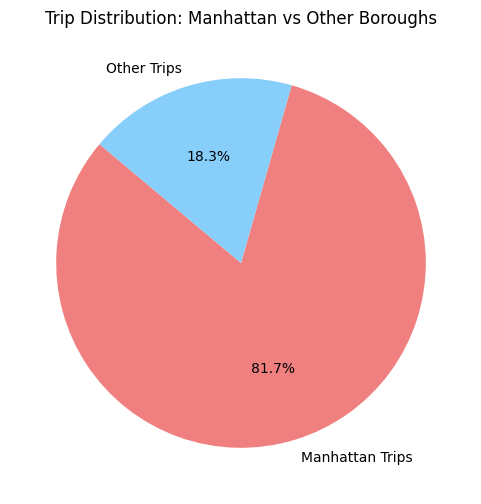

In [384]:
# Plot results on pie chart
labels = ['Manhattan Trips', 'Other Trips']
sizes = [geo_results['Manhattan Trips'], geo_results['Total Trips'] - geo_results['Manhattan Trips']]
colors = ['lightcoral', 'lightskyblue']

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Trip Distribution: Manhattan vs Other Boroughs')

In [385]:
# Zone segmentation by demand
print("\nSegmenting zones by demand...")
pu_stats, do_stats = segment_zones_by_demand()

styled_pu = (pu_stats.head(10).sort_values(['taxi_zone_id'])
    .style
    .set_table_styles([
        {"selector": "table", "props": [("border-collapse", "collapse"), ("width", "100%")]},
        {"selector": "th, td", "props": [("border", "1px solid #999"), ("padding", "6px")]},
        {"selector": "th", "props": [("background", "steelblue"), ("text-align", "center")]},
        {"selector": "td", "props": [("background", "white"), ("color", "black")]},
    ])
    .hide(axis="index")
)

display(styled_pu)

styled_do = (do_stats.head(10).sort_values(['taxi_zone_id'])
    .style
    .set_table_styles([
        {"selector": "table", "props": [("border-collapse", "collapse"), ("width", "100%")]},
        {"selector": "th, td", "props": [("border", "1px solid #999"), ("padding", "6px")]},
        {"selector": "th", "props": [("background", "steelblue"), ("text-align", "center")]},
        {"selector": "td", "props": [("background", "white"), ("color", "black")]},
    ])
    .hide(axis="index")
)

display(styled_do)


Segmenting zones by demand...

Zone-Hour Segmentation Summary:
Total zone-hour combinations: 5708

Demand distribution:
demand_tier
Low       1934
High      1903
Medium    1871
Name: count, dtype: int64

Top 10 zone-hour combinations by demand:
      taxi_zone_id  hour  avg_trips_per_hour  avg_revenue_per_hour demand_tier
2758           237    18          865.033333           7016.950000        High
1725           161    18          837.133333           7940.576667        High
5024           161    19          835.800000           7634.810000        High
3812           237    15          830.466667           6751.400000        High
3761           230    22          822.733333           7616.483333        High
136            237    14          814.833333           6665.060000        High
5634           162    19          803.033333           7438.110000        High
4363           234    19          786.766667           7054.760000        High
4805           237    19          776.13333

taxi_zone_id,hour,pickup_trips_count,pickup_avg_fare,pickup_total_fare,pickup_avg_distance,pickup_avg_mile_cost,days_observed,avg_trips_per_hour,avg_revenue_per_hour,demand_tier
37,6,150,9.973333,1496.000000,2.351667,4.863415,88,1.704545,17.000000,Medium
49,5,383,9.024804,3456.500000,2.149399,5.748543,88,4.352273,39.278409,High
74,10,10765,8.615588,92746.800000,1.717718,6.065741,88,122.329545,1053.940909,High
94,9,67,9.604478,643.500000,2.096119,6.130182,86,0.779070,7.482558,Medium
119,12,124,7.875000,976.500000,1.614758,7.902476,88,1.409091,11.096591,Medium
197,12,117,9.683761,1133.000000,1.897863,5.951763,88,1.329545,12.875000,Medium
209,15,626,10.853834,6794.500000,2.227811,6.386830,30,20.866667,226.483333,High
236,9,19397,8.745476,169636.000000,1.443012,7.157866,88,220.420455,1927.681818,High
248,10,27,11.166667,301.500000,2.799630,4.584006,81,0.333333,3.722222,Low
263,15,8173,7.946140,64943.800000,1.329790,7.248616,87,93.942529,746.480460,High


taxi_zone_id,hour,dropoff_trips_count,dropoff_total_fare,days_observed,avg_dropoffs_per_hour,dropoff_tier
28,21,892,7606.500000,88,10.136364,Medium
45,5,174,1650.000000,87,2.000000,Medium
64,8,1,8.000000,0,1.000000,Low
89,1,725,8803.000000,88,8.238636,Medium
159,20,655,6583.000000,88,7.443182,Medium
174,4,31,397.000000,84,0.369048,Low
183,13,15,162.000000,81,0.185185,Low
195,9,618,5918.000000,88,7.022727,Medium
218,0,125,1567.000000,85,1.470588,Medium
235,16,362,4257.000000,88,4.113636,Medium


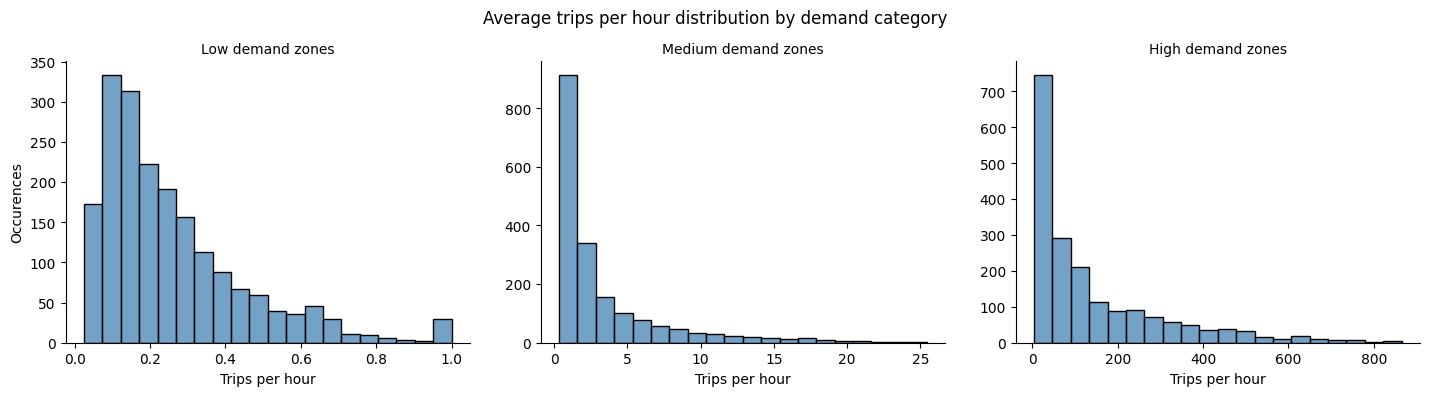

In [386]:
# Plot trips count distribution for each demand category
g = sns.FacetGrid(pu_stats, col='demand_tier', col_order=['Low', 'Medium', 'High'], sharey=False, sharex=False, height=4, aspect=1.2)
g.map_dataframe(sns.histplot, x='avg_trips_per_hour', bins=20, color='steelblue')
g.set_axis_labels("Trips per hour", "Occurences")
g.set_titles(col_template="{col_name} demand zones")
g.figure.subplots_adjust(top=0.85)
g.figure.suptitle("Average trips per hour distribution by demand category")

plt.show()


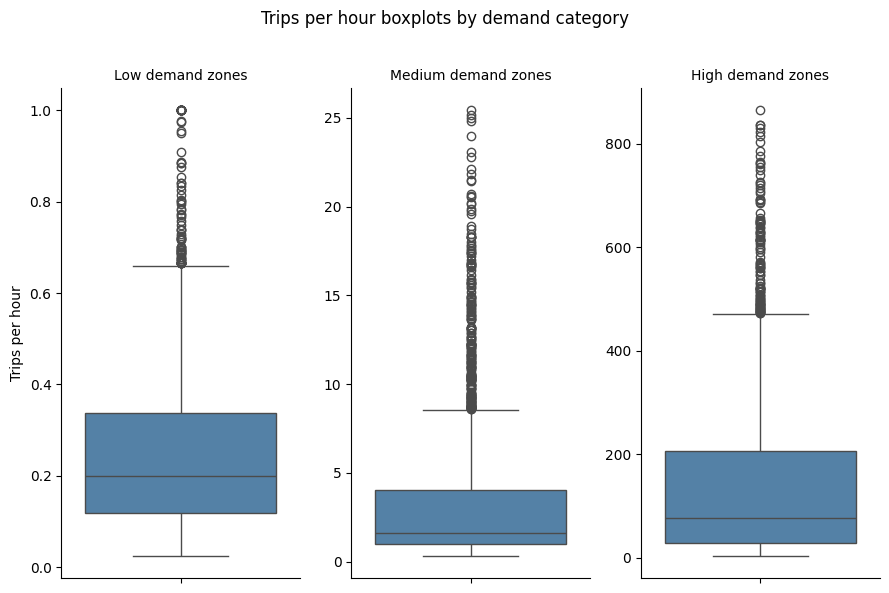

In [387]:
# Plot trips count boxplot for each demand category
g = sns.FacetGrid(pu_stats, col='demand_tier', col_order=['Low', 'Medium', 'High'], sharey=False, sharex=False, height=6, aspect=0.5)
g.map_dataframe(sns.boxplot, y='avg_trips_per_hour', color='steelblue')
g.set_axis_labels("", "Trips per hour")
g.set_titles(col_template="{col_name} demand zones")
g.figure.subplots_adjust(top=0.85)
g.figure.suptitle("Trips per hour boxplots by demand category")

plt.show()

In [388]:
pu_stats.describe()

,taxi_zone_id,hour,pickup_trips_count,pickup_avg_fare,pickup_total_fare,pickup_avg_distance,pickup_avg_mile_cost,days_observed,avg_trips_per_hour,avg_revenue_per_hour
count,5708.000000,5708.000000,5708.000000,5708.000000,5708.000000,5708.000000,5667.000000,5708.000000,5708.000000,5708.000000
mean,136.341275,11.576734,1974.566573,9.358649,17696.315909,2.039676,6.746669,62.696917,48.959038,441.191492
std,76.603855,6.923262,3913.691395,1.880990,34773.086564,0.694550,9.310136,29.053987,114.862266,1030.313378
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025000,0.000000
25%,69.000000,6.000000,14.000000,8.562936,136.000000,1.672451,5.079774,30.000000,0.333333,3.069755
50%,139.000000,12.000000,128.000000,9.203612,1191.500000,1.946382,5.801405,80.000000,1.597701,15.508721
75%,203.000000,18.000000,1832.500000,10.057377,16944.125000,2.290000,6.655874,88.000000,28.779545,265.877841
max,265.000000,23.000000,25951.000000,22.000000,238217.300000,6.500000,300.000007,89.000000,865.033333,7940.576667


In [389]:
# Add columns with price and trips count logs
zone_stats_logs = pu_stats.copy()

# Prepare dataset for taking logs
zone_stats_logs = zone_stats_logs[(zone_stats_logs['pickup_avg_fare'] > 0) & (zone_stats_logs['avg_trips_per_hour'] > 0)]

# Take logs for log-log regression
zone_stats_logs['log_demand'] = np.log(zone_stats_logs['avg_trips_per_hour'])
zone_stats_logs['log_price'] = np.log(zone_stats_logs['pickup_avg_fare'])

# Sort dataset by zone and hour
zone_stats_logs = zone_stats_logs.sort_values(['taxi_zone_id', 'hour'])


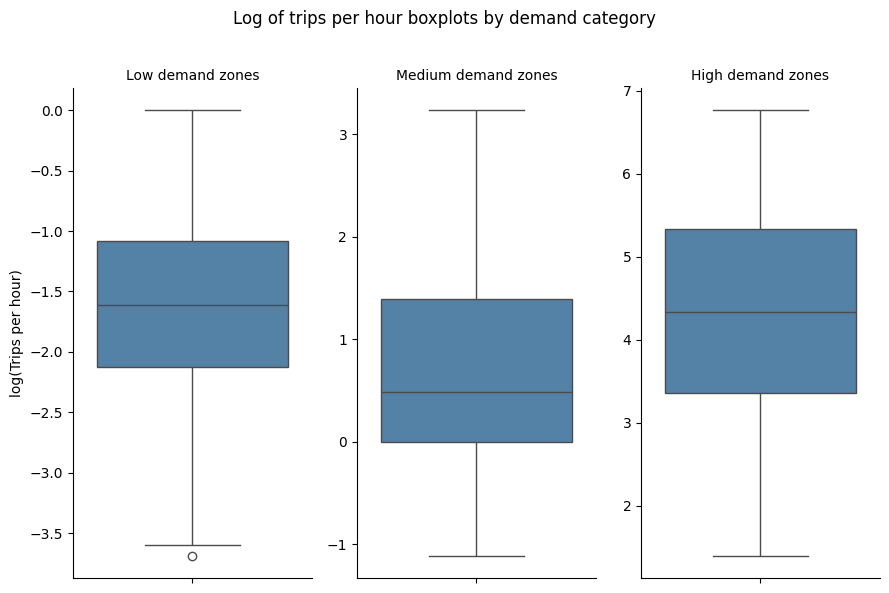

In [390]:
# Plot boxplots for trip count logs
g = sns.FacetGrid(zone_stats_logs, col='demand_tier', col_order=['Low', 'Medium', 'High'], sharey=False, sharex=False, height=6, aspect=0.5)
g.map_dataframe(sns.boxplot, y='log_demand', color='steelblue')
g.set_axis_labels("", "log(Trips per hour)")
g.set_titles(col_template="{col_name} demand zones")
g.figure.subplots_adjust(top=0.85)
g.figure.suptitle("Log of trips per hour boxplots by demand category")

plt.show()

In [414]:
# Price elasticity estimation
elasticity = estimate_demand_elasticity(zone_stats_logs)

elasticity_tbl = pd.DataFrame(elasticity, index=[0])

styled = (
    elasticity_tbl
    .style
    .set_table_styles([
        {"selector": "table", "props": [("border-collapse", "collapse"), ("width", "100%")]},
        {"selector": "th, td", "props": [("border", "1px solid #999"), ("padding", "6px")]},
        {"selector": "th", "props": [("background", "steelblue"), ("text-align", "center")]},
        {"selector": "td", "props": [("background", "white"), ("color", "black")]},
    ])
    .hide(axis="index")
)

display(styled)



Estimating elasticity by demand tier...


High,High_R2_train,High_R2_test,Medium,Medium_R2_train,Medium_R2_test,Low,Low_R2_train,Low_R2_test
-2.394086,0.263888,0.238939,-0.029101,0.125547,0.154206,-0.143750,0.103243,0.069592


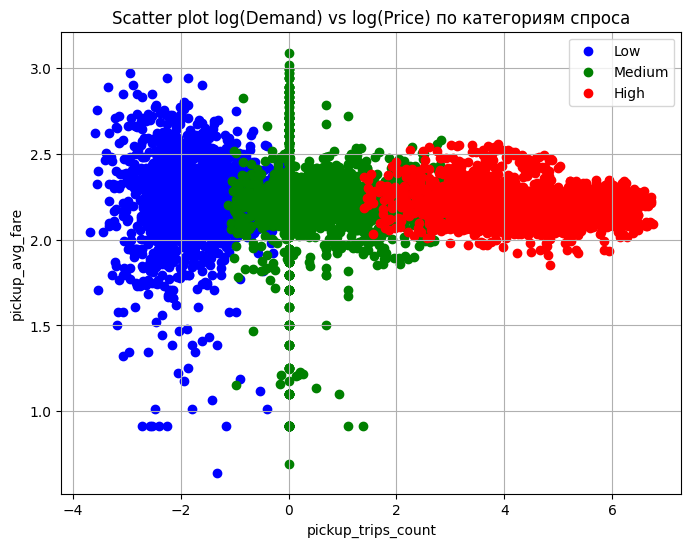

In [392]:
# Цвета для категорий
colors = {'Low': 'blue', 'Medium': 'green', 'High': 'red'}

# Построение scatter plot
plt.figure(figsize=(8,6))
for tier in zone_stats_logs['demand_tier'].unique():
    subset = zone_stats_logs[zone_stats_logs['demand_tier'] == tier]
    plt.scatter(subset['log_demand'], subset['log_price'], 
                label=tier, color=colors[tier])

plt.xlabel('pickup_trips_count')
plt.ylabel('pickup_avg_fare')
plt.title('Scatter plot log(Demand) vs log(Price) по категориям спроса')
plt.legend()
plt.grid(True)
plt.show()

D:\Temp\ipykernel_19492\4105330163.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


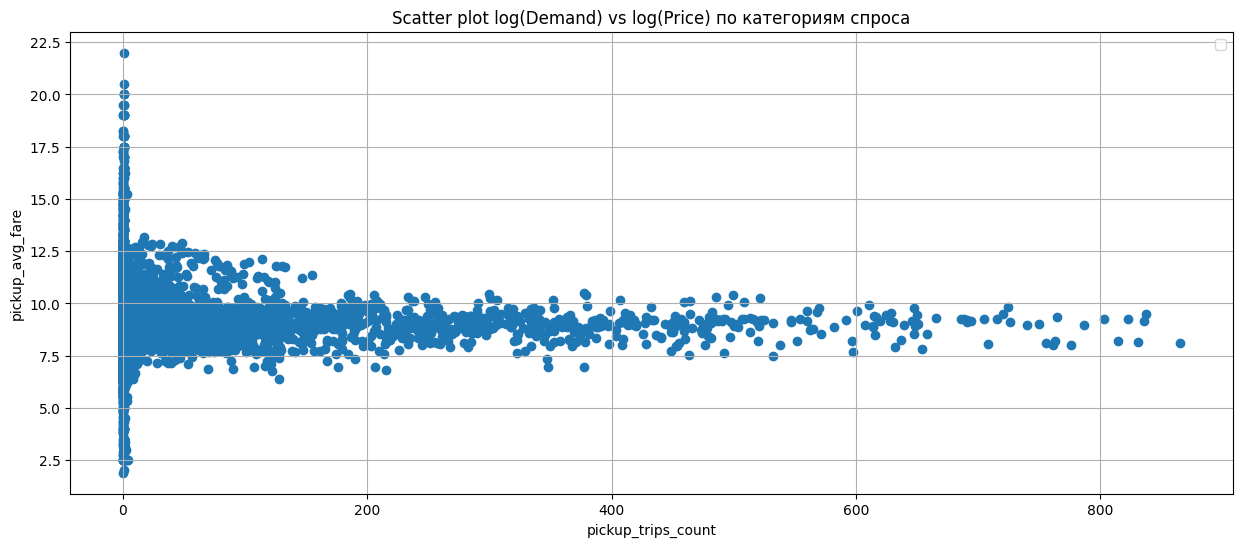

In [393]:
plt.figure(figsize=(15,6))
plt.scatter(zone_stats_logs['avg_trips_per_hour'], zone_stats_logs['pickup_avg_fare'], 
                )

plt.xlabel('pickup_trips_count')
plt.ylabel('pickup_avg_fare')
plt.title('Scatter plot log(Demand) vs log(Price) по категориям спроса')
plt.legend()
plt.grid(True)
plt.show()

In [508]:
# Scenario simulation
print("\nSimulating pricing scenarios...")
results_df, scenarios = simulate_pricing_scenarios(pu_stats, do_stats, elasticity)


Simulating pricing scenarios...
   taxi_zone_id  hour  pickup_trips_count  pickup_avg_fare  pickup_total_fare  \
0           197    12                 117         9.683761             1133.0   
1           209    15                 626        10.853834             6794.5   
2           119    12                 124         7.875000              976.5   
3           248    10                  27        11.166667              301.5   
4           236     9               19397         8.745476           169636.0   
5           263    15                8173         7.946140            64943.8   
6            94     9                  67         9.604478              643.5   
7            74    10               10765         8.615588            92746.8   
8            49     5                 383         9.024804             3456.5   
9            37     6                 150         9.973333             1496.0   

   avg_trips_per_hour demand_tier dropoff_tier      trip_type  elasticity  

In [477]:
# Show scenarios parameters
scenarios_df = pd.DataFrame.from_dict(scenarios, orient='index')
styled = (
    scenarios_df
    .style
    .set_table_styles([
        {"selector": "table", "props": [("border-collapse", "collapse"), ("width", "100%")]},
        {"selector": "th, td", "props": [("border", "1px solid #999"), ("padding", "6px")]},
        {"selector": "th", "props": [("background", "steelblue"), ("text-align", "center")]},
        {"selector": "td", "props": [("background", "white"), ("color", "black")]},
    ])
    .hide(axis="index")
)

display(styled)


High-High,High-Medium,High-Low,Medium-High,Medium-Medium,Medium-Low,Low-High,Low-Medium,Low-Low
1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1.150000,1.100000,1.000000,1.100000,1.000000,0.950000,1.050000,0.950000,0.900000
1.350000,1.200000,1.050000,1.250000,1.000000,0.950000,1.150000,0.950000,0.800000
1.500000,1.300000,1.100000,1.350000,1.000000,0.900000,1.200000,0.900000,0.700000


In [478]:
# Show scenarios results
styled = (
    results_df
    .style
    .set_table_styles([
        {"selector": "table", "props": [("border-collapse", "collapse"), ("width", "100%")]},
        {"selector": "th, td", "props": [("border", "1px solid #999"), ("padding", "6px")]},
        {"selector": "th", "props": [("background", "steelblue"), ("text-align", "center")]},
        {"selector": "td", "props": [("background", "white"), ("color", "black")]},
    ])
    .hide(axis="index")
)

display(styled)

scenario,baseline_revenue,new_revenue,revenue_change,revenue_change_pct,baseline_trips,new_trips,trips_change_pct
baseline,2517777.472469,2517777.472469,0.000000,0.000000,279410.031357,279410.031357,0.000000
conservative,2517777.472469,2086067.803520,-431709.668948,-17.146458,279410.031357,202173.676445,-27.642656
moderate,2517777.472469,1685770.301643,-832007.170826,-33.045302,279410.031357,140260.984574,-49.801020
aggressive,2517777.472469,1466265.347588,-1051512.124880,-41.763505,279410.031357,110624.157289,-60.407951


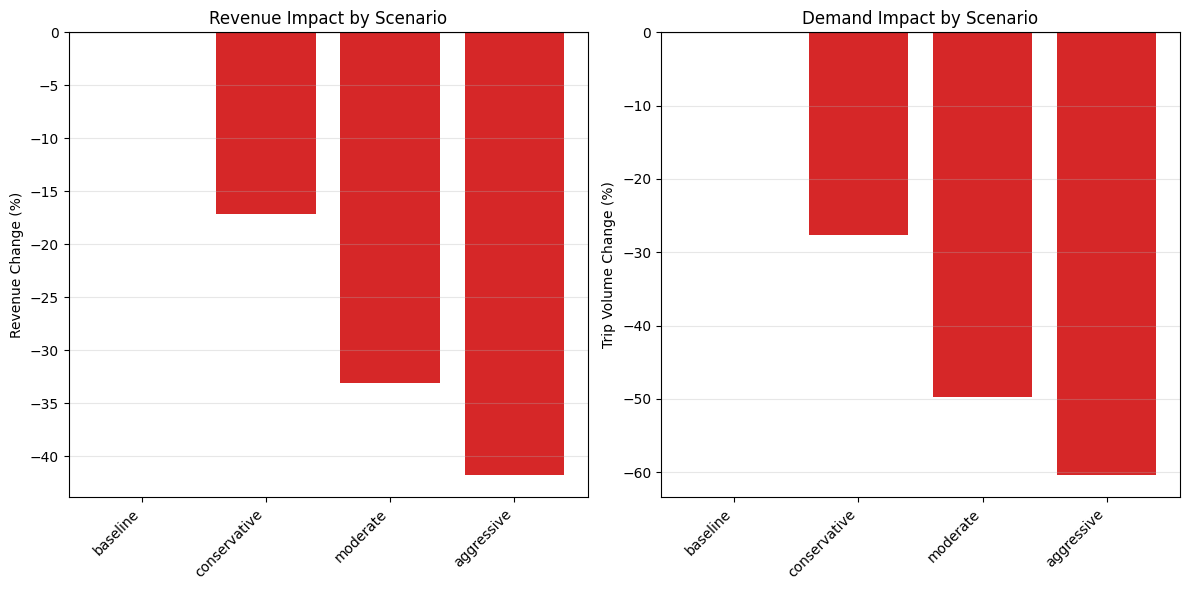

In [539]:
# Plot total revenue impact
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
scenarios = results_df['scenario']
revenue_change = results_df['revenue_change_pct']
colors_scenario = ['#7f7f7f' if x == 'baseline' else '#2ca02c' if x > 0 else '#d62728' 
                    for x in revenue_change]
ax1.bar(range(len(scenarios)), revenue_change, color=colors_scenario)
ax1.set_xticks(range(len(scenarios)))
ax1.set_xticklabels(scenarios, rotation=45, ha='right')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax1.set_ylabel('Revenue Change (%)')
ax1.set_title('Revenue Impact by Scenario')
ax1.grid(axis='y', alpha=0.3)

# Plot trips count impact
trips_change = results_df['trips_change_pct']
colors_trips = ['#7f7f7f' if x == 'baseline' else '#2ca02c' if x > 0 else '#d62728' 
                for x in trips_change]
ax2.bar(range(len(scenarios)), trips_change, color=colors_trips)
ax2.set_xticks(range(len(scenarios)))
ax2.set_xticklabels(scenarios, rotation=45, ha='right')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.set_ylabel('Trip Volume Change (%)')
ax2.set_title('Demand Impact by Scenario')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()
